In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive
%cd MyDrive
%cd 'Colab Notebooks'

%cd ML\ in\ der\ Umformtechnik


Mounted at /content/drive
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/ML in der Umformtechnik


In [ ]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

100%|██████████| 9912422/9912422 [00:00<00:00, 108075039.69it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28869326.46it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27825286.15it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22386050.26it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



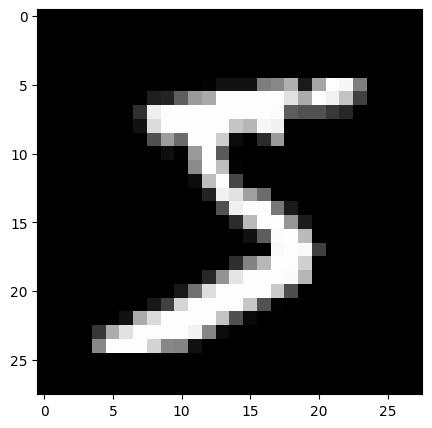

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()

        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 14x14
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 7x7
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # 7x7
        self.bn3 = nn.BatchNorm2d(128)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(128*7*7, 256)
        self.fc2 = nn.Linear(128*7*7, 256)

        # Sampling vector
        self.fc3 = nn.Linear(256, 128*7*7)

        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        ## encode ##
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))

        x = x.view(-1, 128*7*7) # flatten
        mu = self.fc1(x)
        logvar = self.fc2(x)

        z = self.reparameterize(mu, logvar)

        x = self.fc3(z)
        x = x.view(-1, 128, 7, 7) # un-flatten

        ## decode ##
        x = F.leaky_relu(self.bn4(self.t_conv1(x)))
        x = F.leaky_relu(self.bn5(self.t_conv2(x)))
        x = torch.sigmoid(self.conv_out(x))

        return x, mu, logvar

model = ConvDenoiser()
print(model)


ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (fc2): Linear(in_features=6272, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6272, bias=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-

In [ ]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the chosen device
model = model.to(device)

# Assuming your criterion and optimizer are defined elsewhere,
# if you're using SGD, consider using Adam for potentially faster convergence.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # example learning rate, adjust as needed

# number of epochs to train the model
n_epochs = 20

# Define different noise levels
noise_levels = [0.0, 0.2, 0.5]

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    # Iterate over noise_levels within each epoch
    for noise_factor in noise_levels:

        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            images, _ = data

            # Move images to device
            images = images.to(device)

            ## add random noise to the input images
            noisy_imgs = images + noise_factor * torch.randn(*images.shape).to(device)
            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            ## forward pass: compute predicted outputs by passing *noisy* images to the model
            outputs, mu, logvar = model(noisy_imgs)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        # print avg training statistics for each noise level
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tNoise Level: {} \tTraining Loss: {:.6f}'.format(
            epoch,
            noise_factor,
            train_loss
            ))
        # Reset training loss for the next noise level
        train_loss = 0.0


Epoch: 1 	Noise Level: 0.0 	Training Loss: 0.079566
Epoch: 1 	Noise Level: 0.2 	Training Loss: 0.086574
Epoch: 1 	Noise Level: 0.5 	Training Loss: 0.218966
Epoch: 2 	Noise Level: 0.0 	Training Loss: 0.041375
Epoch: 2 	Noise Level: 0.2 	Training Loss: 0.066412
Epoch: 2 	Noise Level: 0.5 	Training Loss: 0.202760
Epoch: 3 	Noise Level: 0.0 	Training Loss: 0.033163
Epoch: 3 	Noise Level: 0.2 	Training Loss: 0.060343
Epoch: 3 	Noise Level: 0.5 	Training Loss: 0.194132
Epoch: 4 	Noise Level: 0.0 	Training Loss: 0.029394
Epoch: 4 	Noise Level: 0.2 	Training Loss: 0.057427
Epoch: 4 	Noise Level: 0.5 	Training Loss: 0.190038
Epoch: 5 	Noise Level: 0.0 	Training Loss: 0.026980
Epoch: 5 	Noise Level: 0.2 	Training Loss: 0.055599
Epoch: 5 	Noise Level: 0.5 	Training Loss: 0.186861
Epoch: 6 	Noise Level: 0.0 	Training Loss: 0.026860
Epoch: 6 	Noise Level: 0.2 	Training Loss: 0.054298
Epoch: 6 	Noise Level: 0.5 	Training Loss: 0.183619
Epoch: 7 	Noise Level: 0.0 	Training Loss: 0.023931
Epoch: 7 	No

In [ ]:
import matplotlib.pyplot as plt

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model_save_path = "./denoising_autoencoder.pth"
torch.save(model.state_dict(), model_save_path)



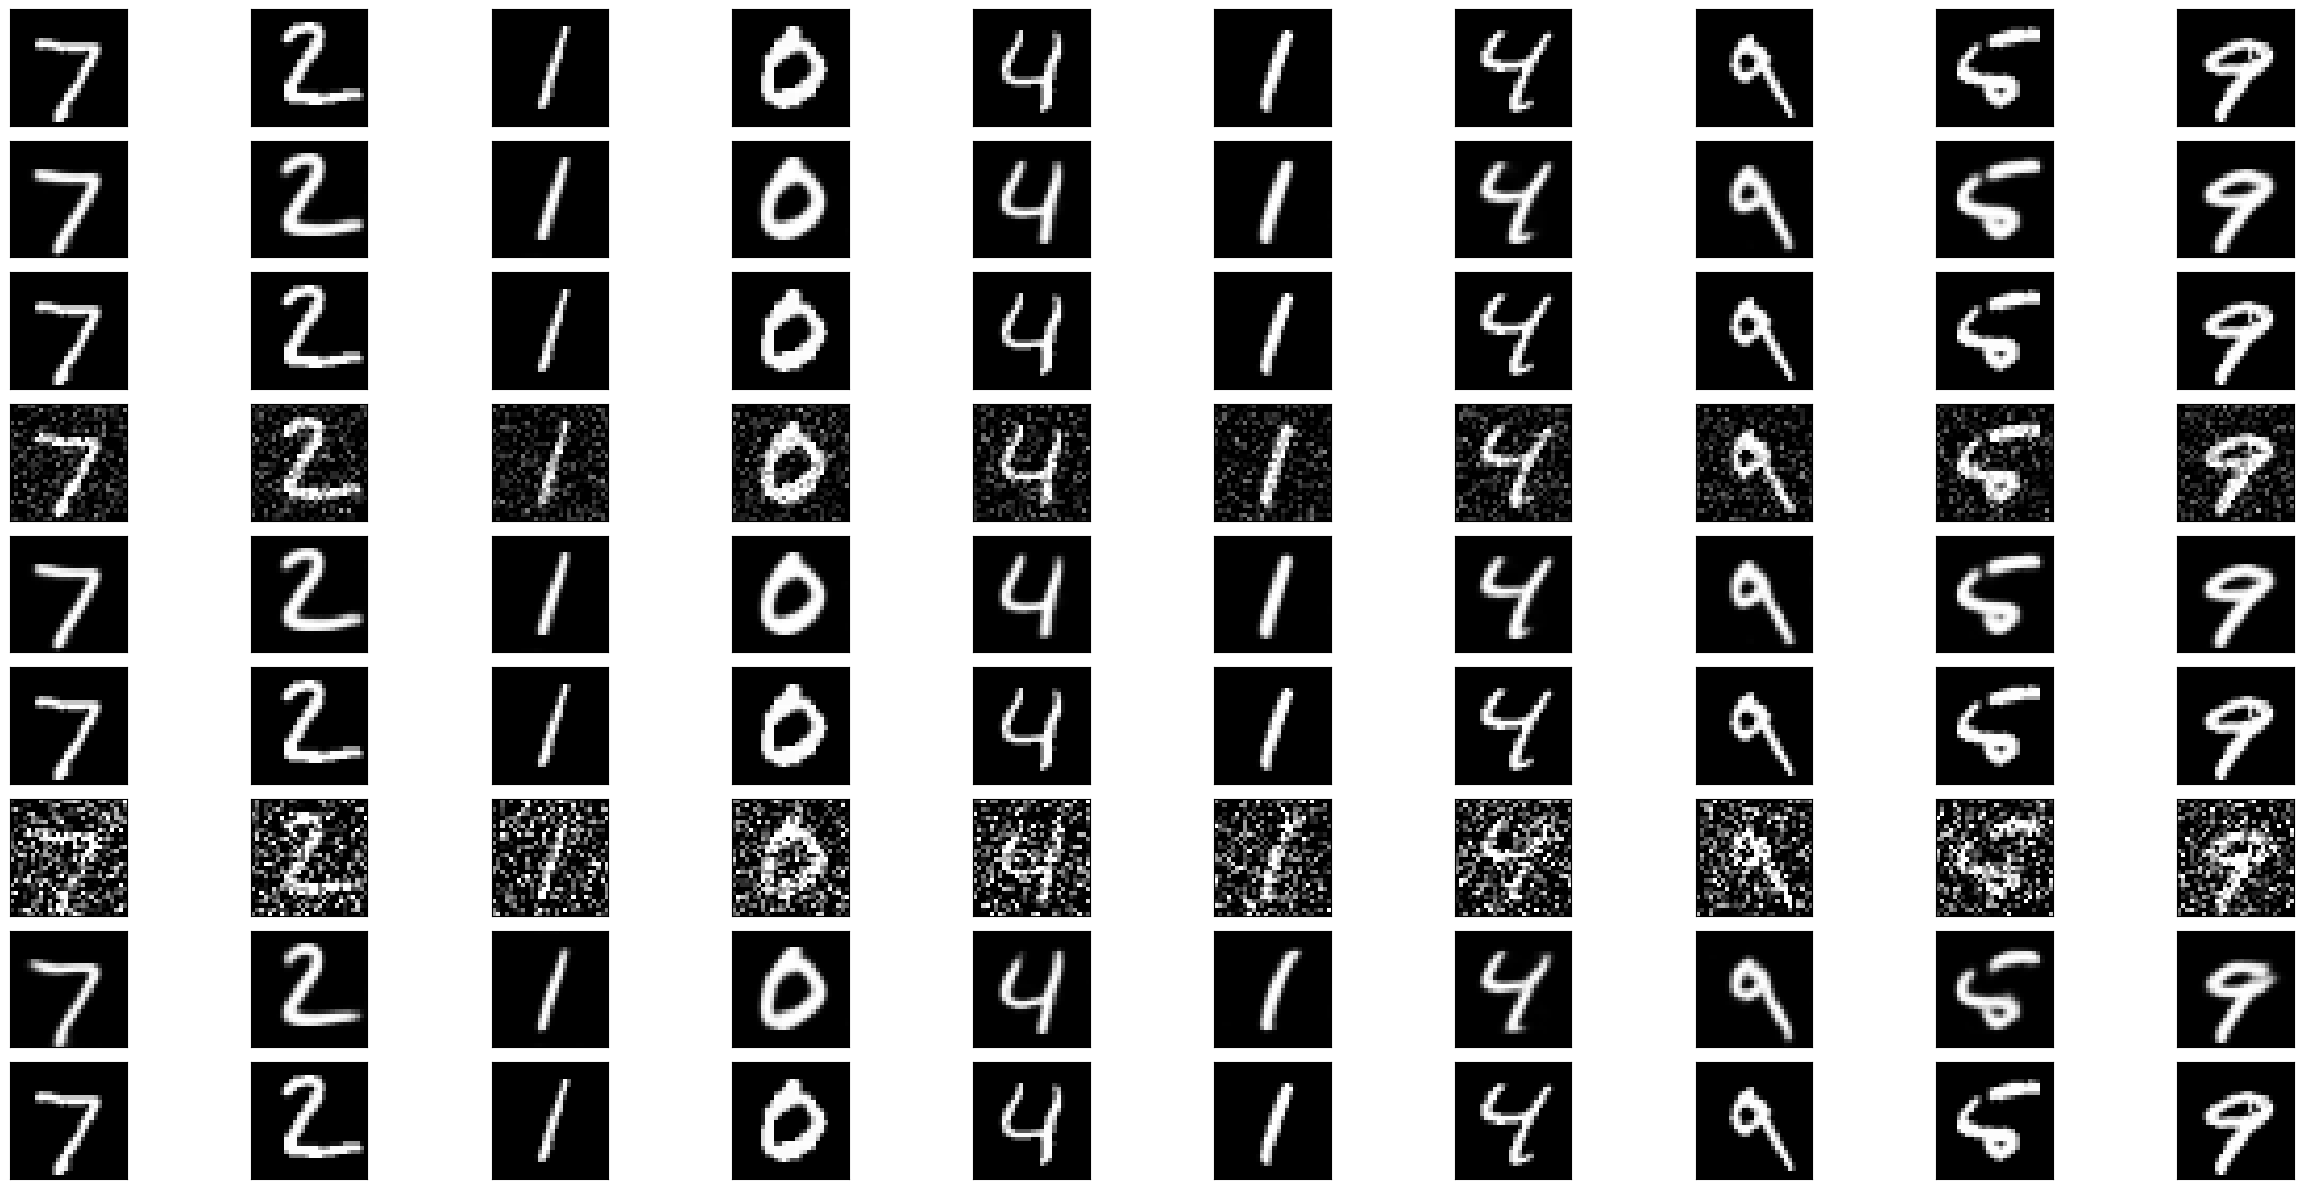

In [ ]:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

# Define different noise levels
noise_levels = [0.0, 0.2, 0.5]

fig, axes = plt.subplots(nrows=3*len(noise_levels), ncols=10, sharex=True, sharey=True, figsize=(25,4*len(noise_levels)))

for idx, noise_factor in enumerate(noise_levels):
    # add noise to the test images
    noisy_imgs = images + noise_factor * torch.randn(*images.shape).to(device)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)

    # get sample outputs
    output, _, _ = model(noisy_imgs)  # Updated to unpack outputs, mu, and logvar
    # move tensors to cpu for visualization
    noisy_imgs = noisy_imgs.cpu().numpy()

    # output is resized into a batch of images
    output = output.view(images.size(0), 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.detach().cpu().numpy()

    # Original images
    orig_imgs = images.cpu().numpy()

    # plot the first ten images for each category
    for j in range(10):  # Displaying 10 images per row
        # Display Noised Images
        ax = axes[3*idx, j]
        ax.imshow(np.squeeze(noisy_imgs[j]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display Denoised Images
        ax = axes[3*idx + 1, j]
        ax.imshow(np.squeeze(output[j]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display Original Images
        ax = axes[3*idx + 2, j]
        ax.imshow(np.squeeze(orig_imgs[j]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()